# Plastic Simulation

Please read the notebook on [Hardwall Simulation](Hardwall_Simulation.ipynb) before. 


The method is described in 

Weber, B. et al. Molecular probes reveal deviations from Amontons’ law in multi-asperity frictional contacts. Nature Communications 9, 888 (2018).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from SurfaceTopography import Topography, PlasticTopography
from ContactMechanics import FreeFFTElasticHalfSpace
from ContactMechanics.Factory import make_plastic_system
from ContactMechanics.Tools.Logger import screen

## Prepare Geometry

In [2]:
nx, ny = 128,128

sx = 0.005 # mm
sy = 0.005 # mm

x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2

topography= Topography(- np.sqrt(x**2 + y**2 ) *0.05, physical_sizes=(sx, sy) )


Text(0, 0.5, 'y (mm)')

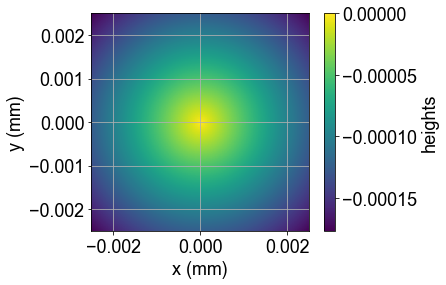

In [3]:
fig, ax = plt.subplots()
plt.colorbar(ax.imshow(topography.heights(), extent=[-sx/2, sx/2, -sy/2, sy/2]), label = "heights")
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

Text(0, 0.5, 'heights (mm)')

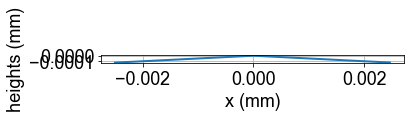

In [4]:
fig, ax = plt.subplots()
ax.plot(x, topography.heights()[:, ny//2])
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("heights (mm)")

## Material Properties

In [5]:
Es = 230000 # MPa
hardness = 6000 # MPa

## setup system

the `make_system` automatically knows it has to do a plastic simulation if we pass a `PlasticTopogaraphy`

In [6]:
system = make_plastic_system(
            substrate = FreeFFTElasticHalfSpace(nb_grid_pts=topography.nb_grid_pts, young=Es, physical_sizes=topography.physical_sizes), 
            surface= PlasticTopography(topography=topography, hardness=hardness)
           )

#### loading history

In [7]:
external_forces = [0.001, 0.005,0.01, 0.02, 0.01, 0.005, 0.001]

#### optional: provide an initial contition
provide initial disp that is nonzero because otherwise the optimizer will begin with full contact area, 
what is far from the solution in this case

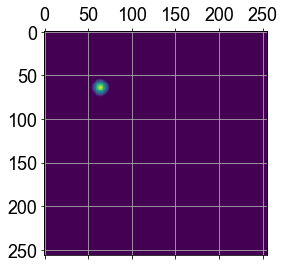

In [8]:
penetration = 0.00002
disp0 = np.zeros(system.substrate.nb_domain_grid_pts)
disp0[system.surface.subdomain_slices] = system.surface.heights() + penetration
disp0 = np.where(disp0 > 0, disp0, 0)
plt.matshow(disp0)

### Simulate

In [9]:
# prepare empty arrays to contain results
offsets = []
plastic_areas = []
contact_areas = []
forces = np.zeros((len(external_forces), *topography.nb_grid_pts)) # forces[timestep,...]: array of forces for each gridpoint
elastic_displacements = np.zeros((len(external_forces), *topography.nb_grid_pts))
plastified_topographies = []

i=0
for external_force in external_forces:
    sol = system.minimize_proxy(external_force=external_force, #load controlled
                                #mixfac = 1e-4,
                                initial_displacements=disp0,
                                pentol=1e-10, # for the default value I had some spiky pressure fields during unloading
                                logger=screen) # display informations about each iteration
    assert sol.success
    disp0 = system.disp
    offsets.append(system.offset)
    plastic_areas.append(system.surface.plastic_area)
    contact_areas.append(system.compute_contact_area())
    
    plastified_topographies.append(system.surface.squeeze())
    #system.surface=PlasticTopography(topography=topography, hardness=hardness) # reset surface
    forces[i,...] = system.force
    elastic_displacements[i, ...] = system.disp[system.surface.subdomain_slices]
    
    i+=1
    #print(np.max(system.surface.plastic_displ))
    #print(np.min(system.surface.plastic_displ))

# {constrained_conjugate_gradients}: maxiter = 100000
# {constrained_conjugate_gradients}: pentol = 1e-10
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   cg         1                   253    1.544189453125e-02    1.086936456054e-03    2.000000000000e-05                    69    4.211425781250e-03
                   cg         2                   253    1.544189453125e-02    1.198198438758e-03    2.046758843494e-05                   101    6.164550781250e-03
                   cg         3                   185    1.129150390625e-02    1.165974641301e-03    2.098395286307e-05                   101    6.164550781250e-03
                   sd         4                   177    1.080322265625e-02    1.139042144424e-03    2.069333846412e-05                   101    6.164550781250e-03
                   cg         5                   161    9.826660156250e-0

# {constrained_conjugate_gradients}: pentol = 1e-10
                   sd         1                  8226    5.020751953125e-01    8.226781155567e-02    9.659954762621e-05                  2556    1.560058593750e-01
                   sd         2                  7573    4.622192382812e-01   -7.245388611211e-02    1.642808079805e-04                  4997    3.049926757812e-01
                   sd         3                  3910    2.386474609375e-01    9.450099693125e-01    3.412950202082e-05                  1443    8.807373046875e-02
                   sd         4                  7062    4.310302734375e-01   -1.115841378732e+01    8.899407153557e-04                  6857    4.185180664062e-01
                   sd         5                  9495    5.795288085938e-01    2.269118126213e+02   -1.136053522996e-02                  9487    5.790405273438e-01
                   sd         6                  6910    4.217529296875e-01    6.325378418992e-02    2.985156000000e-01         

#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd        47                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        48                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        49                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        50                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        51                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                

                   sd        92                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        93                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        94                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        95                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd        96                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                

                   sd       138                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       139                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       140                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       141                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       142                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       143                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                

                   sd       184                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       185                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       186                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd       187                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       188                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                

                   sd       229                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       230                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       231                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       232                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       233                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       234                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                

                   sd       275                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       276                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd       277                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       278                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                   sd       279                  6910    4.217529296875e-01    6.325378417969e-02    1.533980373142e-04                  6909    4.216918945312e-01
                

                   sd       321                   854    5.212402343750e-02    5.806491148018e-03    4.691332827697e-05                   524    3.198242187500e-02
                   sd       322                   829    5.059814453125e-02    5.655223238677e-03    4.613401997521e-05                   510    3.112792968750e-02
                   sd       323                   798    4.870605468750e-02    5.527349808866e-03    4.552341330892e-05                   495    3.021240234375e-02
                   sd       324                   778    4.748535156250e-02    5.424413273318e-03    4.500398910410e-05                   484    2.954101562500e-02
                   sd       325                   760    4.638671875000e-02    5.341613324406e-03    4.458194825671e-05                   476    2.905273437500e-02
                   sd       326                   749    4.571533203125e-02    5.266212295820e-03    4.424039294212e-05                   459    2.801513671875e-02
#            1:s

#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd         8                  9697    5.918579101562e-01   -2.278322000992e+00    4.895854931042e-04                  9280    5.664062500000e-01
                   sd         9                  7367    4.496459960938e-01    4.948671145780e+01   -1.483690150661e-03                  7271    4.437866210938e-01
                   sd        10                  9091    5.548706054688e-01   -2.005481199334e+03    3.298442533548e-02                  9088    5.546875000000e-01
                  mix        11                  7181    4.382934570312e-01    6.574401943786e-02         0                  7181    4.382934570312e-01
                  mix        12                  7397    4.514770507812e-01    2.780176351317e-02    1.743362964028e-04                  2282    1.392822265625e-01
                  mix       

                   sd        54                  1433    8.746337890625e-02    1.027436942313e-02    6.159396821016e-05                   885    5.401611328125e-02
                   sd        55                  1420    8.666992187500e-02    1.021712308345e-02    6.137359676649e-05                   881    5.377197265625e-02
                   sd        56                  1405    8.575439453125e-02    1.017214198368e-02    6.120136518223e-05                   877    5.352783203125e-02
                   sd        57                  1388    8.471679687500e-02    1.013614810707e-02    6.106722695336e-05                   873    5.328369140625e-02
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd        58                  1371    8.367919921875e-02    1.010686273205e-02    6.095727914440e-05                   869    5.303955078125e-02
                

                   sd        12                  3320    2.026367187500e-01    2.257417080605e-02    9.215176401400e-05                  2037    1.243286132812e-01
                   sd        13                  3207    1.957397460938e-01    2.208496357871e-02    9.095788191061e-05                  1987    1.212768554688e-01
                   sd        14                  3131    1.911010742188e-01    2.168005546863e-02    8.996505719562e-05                  1933    1.179809570312e-01
                   sd        15                  3051    1.862182617188e-01    2.134744740149e-02    8.913925105646e-05                  1891    1.154174804688e-01
                   sd        16                  2986    1.822509765625e-01    2.107157915363e-02    8.844818767629e-05                  1851    1.129760742188e-01
                   sd        17                  2946    1.798095703125e-01    2.084697045961e-02    8.788165138571e-05                  1809    1.104125976562e-01
                

                   sd         4                  6482    3.956298828125e-01    3.678501917649e-02    1.192393637715e-04                  3917    2.390747070312e-01
                   sd         5                  5559    3.392944335938e-01    3.340849426687e-02    1.161081194610e-04                  3606    2.200927734375e-01
                   sd         6                  5051    3.082885742188e-01    2.916391237862e-02    1.107922566652e-04                  3005    1.834106445312e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd         7                  4792    2.924804687500e-01    2.704440670852e-02    1.037637284786e-04                  2837    1.731567382812e-01
                   sd         8                  4197    2.561645507812e-01    2.460457207895e-02    9.974662322061e-05                  2541    1.550903320312e-01
                

                   sd         9                  3299    2.013549804688e-01    1.938250430256e-02    8.799822394810e-05                  2090    1.275634765625e-01
                   sd        10                  2978    1.817626953125e-01    1.603021317704e-02    8.459320050732e-05                  1683    1.027221679688e-01
                   sd        11                  2705    1.651000976562e-01    9.270020940945e-03    7.787171222874e-05                   785    4.791259765625e-02
                   sd        12                  2485    1.516723632812e-01    5.906318079357e-03    6.252731159712e-05                   215    1.312255859375e-02
                   sd        13                  1906    1.163330078125e-01    4.978750908143e-03    5.367435326629e-05                    55    3.356933593750e-03
                   sd        14                  1600    9.765625000000e-02    5.005483497937e-03    5.142275729099e-05                     9    5.493164062500e-04
                

                   cg        18                   507    3.094482421875e-02    1.000000000000e-03    3.861403119543e-05                     0    0.000000000000e+00
                   cg        19                   505    3.082275390625e-02    1.000000000000e-03    3.861296231022e-05                     0    0.000000000000e+00
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   cg        20                   505    3.082275390625e-02    1.000000000000e-03    3.861396832732e-05                     0    0.000000000000e+00
                   cg        21                   505    3.082275390625e-02    1.000000000000e-03    3.861592577417e-05                     0    0.000000000000e+00
                   cg        22                   505    3.082275390625e-02    1.000000000000e-03    3.861437013161e-05                     0    0.000000000000e+00
                

## plot pressure distributions and deformed profiles

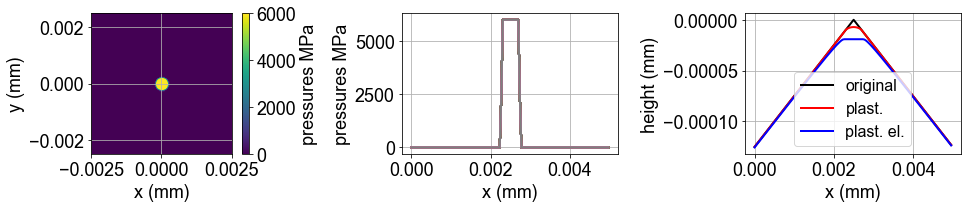

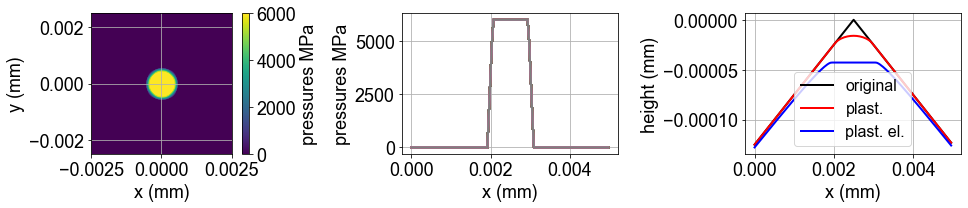

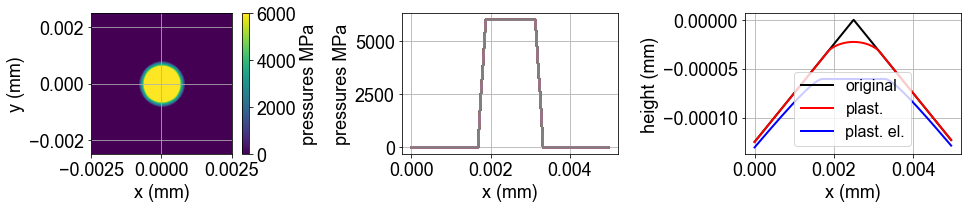

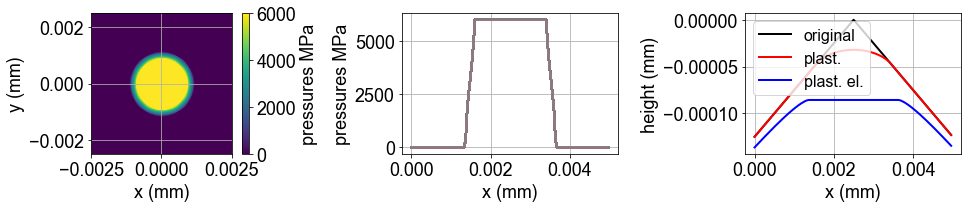

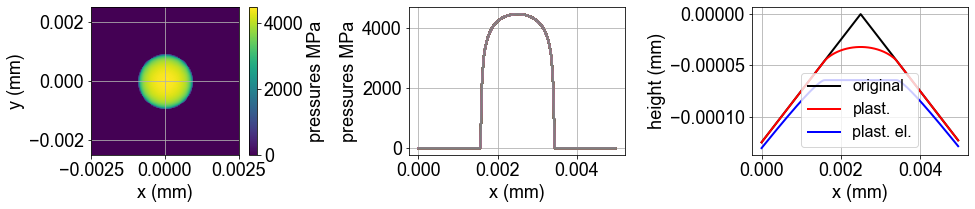

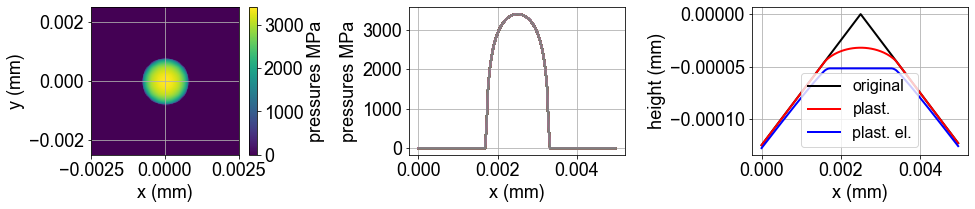

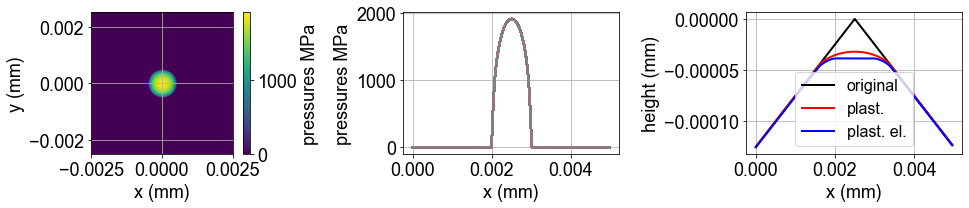

In [10]:
for i in range(len(external_forces)):
    
    fig, (axf, axfcut, axtopcut) = plt.subplots(1,3, figsize=(14,3))
    
    axf.set_xlabel("x (mm)")
    axf.set_ylabel("y (mm)")
        
    axfcut.plot(system.surface.positions()[0], forces[i, :, ny//2]/ system.area_per_pt)
    axfcut.set_xlabel("x")
    axfcut.set_ylabel("pressures MPa")
    
    for a in (axfcut, axtopcut):
        a.set_xlabel("x (mm)")
    axtopcut.set_ylabel("height (mm)")
    
    plt.colorbar(axf.imshow(forces[i,...]/ system.area_per_pt, extent=[-sx/2, sx/2, -sy/2, sy/2]), label="pressures MPa", ax = axf)
    axf.set_aspect(1)
    
    axtopcut.plot(system.surface.positions()[0][:,0], topography.heights()[:, ny//2], 
                  color="k", label = "original")
    axtopcut.plot(system.surface.positions()[0][:,0], plastified_topographies[i].heights()[:, ny//2], 
                  color = "r", label="plast.")
    axtopcut.plot(system.surface.positions()[0][:,0], plastified_topographies[i].heights()[:, ny//2] - elastic_displacements[i,:, ny//2], 
                  c="b", label="plast. el.")
    axtopcut.legend()
    
    fig.tight_layout()

## scalar quantities during loading

Text(0, 0.5, 'Force [N]')

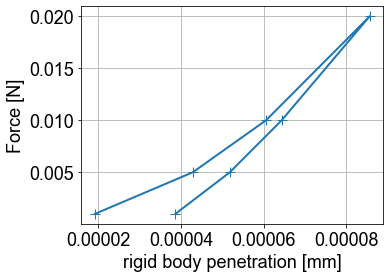

In [11]:
fig, ax = plt.subplots()

ax.plot(offsets, external_forces,"+-")
ax.set_xlabel("rigid body penetration [mm]")
ax.set_ylabel("Force [N]")

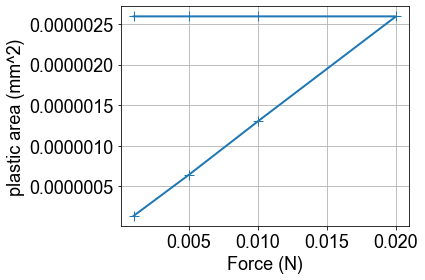

In [12]:
fig, ax = plt.subplots()

ax.plot(external_forces, plastic_areas, "-+")
ax.set_xlabel("Force (N)")
ax.set_ylabel("plastic area (mm^2)")
fig.tight_layout()

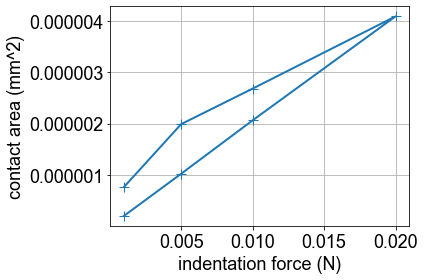

In [13]:
fig, ax = plt.subplots()

ax.plot(external_forces, contact_areas, "+-")
ax.set_xlabel("indentation force (N)")
ax.set_ylabel("contact area (mm^2)")
fig.tight_layout()